Diabetic macular edema (DME) is a common disease of diabetic retinopathy (DR). Due to the infection of DME disease, many patients’ vision is lost. To cure DME eye disease, early detection and treatment are very important and vital steps. 

The main goal of this project is develop an Artificial Intelligence solution that can help to classify OCT. To achieve our goal, Deep-Learning (DL) model will be used to predict the risk of patients with diabetes developing diabetic retinopathy. The outcomes would improve patient access to treatment and ease pressures on time and resources in ophthalmology clinics.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import sys
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tensorflow.keras import optimizers

In [2]:
labels = ['DME','NORMAL']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]   
                #cropped_image = img_arr[20:1900, 340:2210]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr,class_num])
                
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train =get_data('Input/Train')
test =get_data('Input/Test')

'NoneType' object is not subscriptable


<ipython-input-2-e1896034057b>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [4]:
train.shape

(2450, 2)

In [5]:
test.shape

(1050, 2)

In [6]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_val.append(feature)
    y_val.append(label)

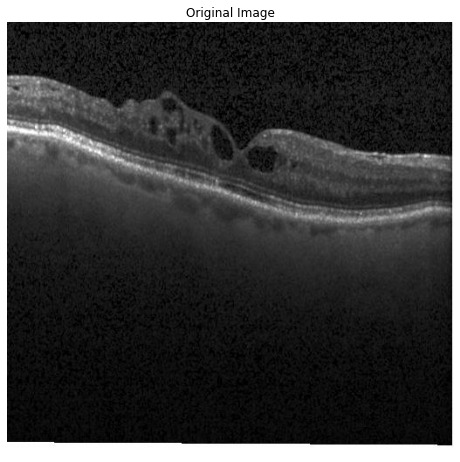

In [7]:
img = cv2.imread('DME-30521-1.jpeg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img,cmap="gray")
plt.axis('off')
plt.title("Original Image")
plt.show()

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [9]:

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

Will build Convolutional Neural Networks (CNN) models with different Convolutional layes then select the best.

In [11]:
#1 Convolutional layes

cnn1 = tf.keras.models.Sequential()

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
cnn1.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same' ,strides=2))

cnn1.add(tf.keras.layers.Flatten())
cnn1.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn1.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(lr=LEARNING_RATE)

cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
history1=cnn1.fit(x_train, y_train, validation_split=0.2, epochs=20, callbacks=[es])


/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
62/62 [==============================] - 17s 267ms/step - loss: 0.9860 - accuracy: 0.6372 - val_loss: 0.5051 - val_accuracy: 0.8551
Epoch 2/20
62/62 [==============================] - 16s 262ms/step - loss: 0.5305 - accuracy: 0.7362 - val_loss: 1.1292 - val_accuracy: 0.2612
Epoch 3/20
62/62 [==============================] - 16s 265ms/step - loss: 0.3724 - accuracy: 0.8408 - val_loss: 0.6894 - val_accuracy: 0.6429
Epoch 4/20
62/62 [==============================] - 16s 265ms/step - loss: 0.2190 - accuracy: 0.9270 - val_loss: 1.8474 - val_accuracy: 0.1939
Epoch 00004: early stopping


In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, cnn1.predict_classes(x_val))

/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.6342857142857142

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

predictions1 = cnn1.predict_classes(x_val)
predictions11 = predictions1.reshape(1,-1)[0]
print(classification_report(y_val, predictions1, target_names = ['DME (Class 0)','Normal (Class 1)']))


                  precision    recall  f1-score   support

   DME (Class 0)       0.59      0.92      0.72       525
Normal (Class 1)       0.82      0.35      0.49       525

        accuracy                           0.63      1050
       macro avg       0.70      0.63      0.60      1050
    weighted avg       0.70      0.63      0.60      1050



In [27]:
# calculate AUC

import sklearn.metrics as metrics

auc1 = metrics.roc_auc_score(y_val, predictions1)
print('AUC: %.3f' % auc1)

AUC: 0.634


In [28]:
#The best model is cnn5
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                25233472  
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 25,236,481
Trainable params: 25,236,481
Non-trainable params: 0
__________________________________________

In [29]:
test_loss, test_acc = cnn1.evaluate(x_val,  y_val, verbose=2)

33/33 - 2s - loss: 0.8281 - accuracy: 0.6343


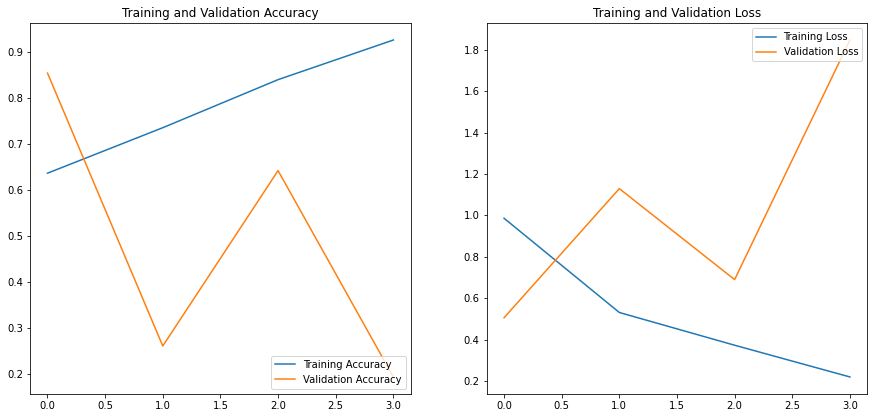

In [30]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
#2 Convolutional layes

cnn2 = tf.keras.models.Sequential()
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same' ,strides=2))
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn2.add(tf.keras.layers.Flatten())
cnn2.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn2.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(lr=LEARNING_RATE)

cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
history2=cnn2.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[es])



/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
62/62 [==============================] - 24s 387ms/step - loss: 0.6067 - accuracy: 0.6694 - val_loss: 0.7294 - val_accuracy: 0.5347
Epoch 2/20
62/62 [==============================] - 24s 382ms/step - loss: 0.4621 - accuracy: 0.7862 - val_loss: 1.3849 - val_accuracy: 0.3469
Epoch 3/20
62/62 [==============================] - 24s 384ms/step - loss: 0.3123 - accuracy: 0.8658 - val_loss: 1.2761 - val_accuracy: 0.4102
Epoch 4/20
62/62 [==============================] - 24s 382ms/step - loss: 0.1600 - accuracy: 0.9485 - val_loss: 0.5068 - val_accuracy: 0.7898
Epoch 5/20
62/62 [==============================] - 24s 383ms/step - loss: 0.0704 - accuracy: 0.9796 - val_loss: 1.2136 - val_accuracy: 0.6245
Epoch 6/20
62/62 [==============================] - 24s 384ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.9059 - val_accuracy: 0.7429
Epoch 7/20
62/62 [==============================] - 24s 385ms/step - loss: 0.0120 - accuracy: 0.9985 - val_loss: 1.6113 - val_accuracy: 0.6082

In [14]:
accuracy_score(y_val, cnn2.predict_classes(x_val))

0.7409523809523809

In [31]:
predictions2 = cnn2.predict_classes(x_val)
predictions22 = predictions2.reshape(1,-1)[0]
print(classification_report(y_val, predictions2, target_names = ['DME (Class 0)','Normal (Class 1)']))


/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

   DME (Class 0)       0.72      0.79      0.75       525
Normal (Class 1)       0.77      0.69      0.73       525

        accuracy                           0.74      1050
       macro avg       0.74      0.74      0.74      1050
    weighted avg       0.74      0.74      0.74      1050



In [32]:
# calculate AUC

import sklearn.metrics as metrics

auc2 = metrics.roc_auc_score(y_val, predictions2)
print('AUC: %.3f' % auc2)

AUC: 0.741


In [33]:
#The best model is cnn5
cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6195264   
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

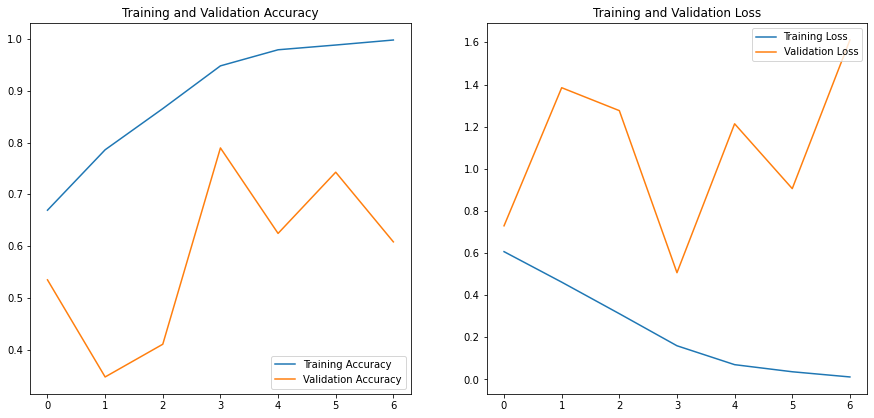

In [34]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
#3 Convolutional layes

cnn3 = tf.keras.models.Sequential()
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
cnn3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same' ,strides=2))
cnn3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn3.add(tf.keras.layers.Flatten())
cnn3.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn3.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(lr=LEARNING_RATE)

cnn3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
history3=cnn3.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[es])

Epoch 1/20
62/62 [==============================] - 26s 418ms/step - loss: 0.6386 - accuracy: 0.6372 - val_loss: 0.8356 - val_accuracy: 0.3939
Epoch 2/20
62/62 [==============================] - 26s 413ms/step - loss: 0.5675 - accuracy: 0.7148 - val_loss: 0.7853 - val_accuracy: 0.4184
Epoch 3/20
62/62 [==============================] - 26s 412ms/step - loss: 0.4624 - accuracy: 0.7816 - val_loss: 1.0780 - val_accuracy: 0.5143
Epoch 4/20
62/62 [==============================] - 26s 413ms/step - loss: 0.3316 - accuracy: 0.8500 - val_loss: 0.7534 - val_accuracy: 0.6306
Epoch 5/20
62/62 [==============================] - 26s 413ms/step - loss: 0.2587 - accuracy: 0.9041 - val_loss: 0.3877 - val_accuracy: 0.8408
Epoch 6/20
62/62 [==============================] - 26s 412ms/step - loss: 0.2058 - accuracy: 0.9204 - val_loss: 0.8001 - val_accuracy: 0.6694
Epoch 7/20
62/62 [==============================] - 26s 412ms/step - loss: 0.1252 - accuracy: 0.9597 - val_loss: 0.9832 - val_accuracy: 0.6571

In [16]:
accuracy_score(y_val, cnn3.predict_classes(x_val))

0.7447619047619047

In [35]:
predictions3 = cnn3.predict_classes(x_val)
predictions33 = predictions3.reshape(1,-1)[0]
print(classification_report(y_val, predictions3, target_names = ['DME (Class 0)','Normal (Class 1)']))

/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

   DME (Class 0)       0.76      0.71      0.74       525
Normal (Class 1)       0.73      0.78      0.75       525

        accuracy                           0.74      1050
       macro avg       0.75      0.74      0.74      1050
    weighted avg       0.75      0.74      0.74      1050



In [36]:
# calculate AUC

import sklearn.metrics as metrics

auc3 = metrics.roc_auc_score(y_val, predictions3)
print('AUC: %.3f' % auc3)

AUC: 0.745


In [37]:
#The best model is cnn5
cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 23328)            

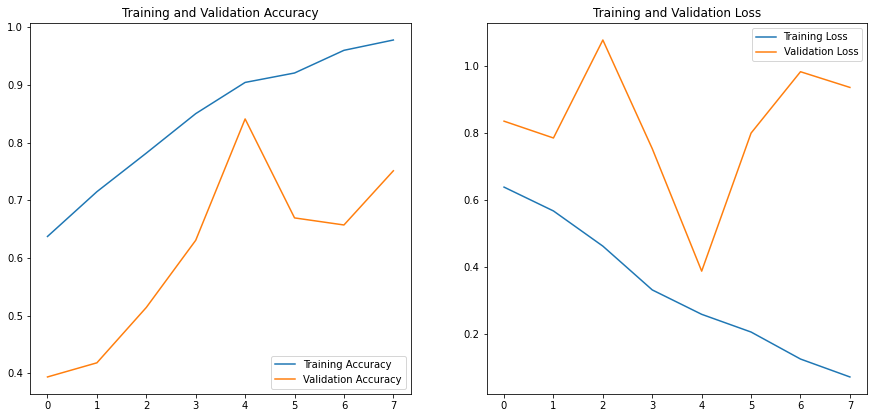

In [38]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
#4 Convolutional layes

cnn4 = tf.keras.models.Sequential()
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
cnn4.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same' ,strides=2))
cnn4.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn4.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn4.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn4.add(tf.keras.layers.Flatten())
cnn4.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn4.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn4.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(lr=LEARNING_RATE)

cnn4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
history4=cnn4.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[es])

Epoch 1/20
62/62 [==============================] - 26s 422ms/step - loss: 0.6261 - accuracy: 0.6536 - val_loss: 0.9811 - val_accuracy: 0.2286
Epoch 2/20
62/62 [==============================] - 26s 418ms/step - loss: 0.5024 - accuracy: 0.7571 - val_loss: 0.9475 - val_accuracy: 0.5449
Epoch 3/20
62/62 [==============================] - 26s 418ms/step - loss: 0.3584 - accuracy: 0.8464 - val_loss: 0.7485 - val_accuracy: 0.6898
Epoch 4/20
62/62 [==============================] - 26s 418ms/step - loss: 0.2800 - accuracy: 0.8913 - val_loss: 0.8753 - val_accuracy: 0.6408
Epoch 5/20
62/62 [==============================] - 26s 416ms/step - loss: 0.2231 - accuracy: 0.9158 - val_loss: 1.0268 - val_accuracy: 0.6816
Epoch 6/20
62/62 [==============================] - 26s 416ms/step - loss: 0.1802 - accuracy: 0.9286 - val_loss: 0.5524 - val_accuracy: 0.8041
Epoch 7/20
62/62 [==============================] - 26s 418ms/step - loss: 0.1602 - accuracy: 0.9372 - val_loss: 0.5925 - val_accuracy: 0.8020

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, cnn4.predict_classes(x_val))

0.7904761904761904

In [39]:

predictions4 = cnn4.predict_classes(x_val)
predictions44 = predictions4.reshape(1,-1)[0]
print(classification_report(y_val, predictions4, target_names = ['DME (Class 0)','Normal (Class 1)']))

/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

   DME (Class 0)       0.82      0.75      0.78       525
Normal (Class 1)       0.77      0.83      0.80       525

        accuracy                           0.79      1050
       macro avg       0.79      0.79      0.79      1050
    weighted avg       0.79      0.79      0.79      1050



In [40]:
# calculate AUC

import sklearn.metrics as metrics

auc4 = metrics.roc_auc_score(y_val, predictions4)
print('AUC: %.3f' % auc4)

AUC: 0.790


In [41]:
#The best model is cnn5
cnn4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 32)       

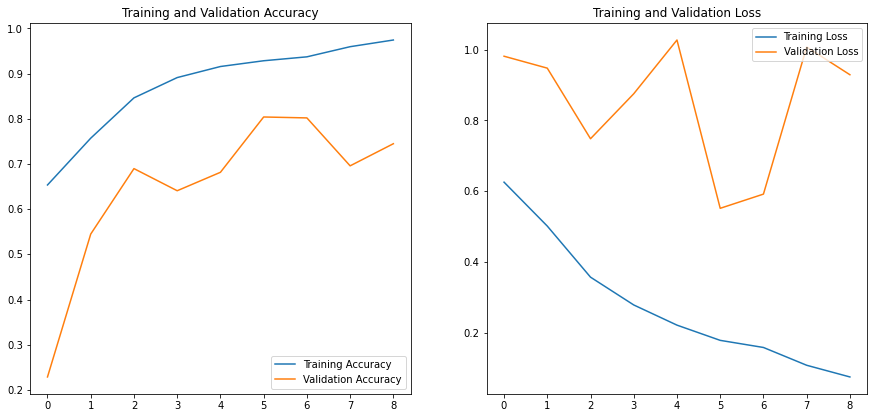

In [42]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
#5 Convolutional layes

cnn5 = tf.keras.models.Sequential()
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
cnn5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same' ,strides=2))
cnn5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn5.add(tf.keras.layers.MaxPool2D(pool_size=2,padding='same', strides=2))
cnn5.add(tf.keras.layers.Flatten())
cnn5.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn5.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn5.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(lr=LEARNING_RATE)

cnn5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
history5=cnn5.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[es])

Epoch 1/20
62/62 [==============================] - 27s 424ms/step - loss: 0.6319 - accuracy: 0.6276 - val_loss: 1.1447 - val_accuracy: 0.1204
Epoch 2/20
62/62 [==============================] - 26s 420ms/step - loss: 0.5743 - accuracy: 0.7153 - val_loss: 0.7647 - val_accuracy: 0.5878
Epoch 3/20
62/62 [==============================] - 26s 420ms/step - loss: 0.4593 - accuracy: 0.7959 - val_loss: 0.8454 - val_accuracy: 0.5245
Epoch 4/20
62/62 [==============================] - 26s 421ms/step - loss: 0.3521 - accuracy: 0.8423 - val_loss: 1.2324 - val_accuracy: 0.4816
Epoch 5/20
62/62 [==============================] - 26s 419ms/step - loss: 0.3121 - accuracy: 0.8658 - val_loss: 0.9021 - val_accuracy: 0.6327
Epoch 00005: early stopping


In [24]:
accuracy_score(y_val, cnn5.predict_classes(x_val))

0.8152380952380952

In [43]:
predictions5 = cnn5.predict_classes(x_val)
predictions55 = predictions5.reshape(1,-1)[0]
print(classification_report(y_val, predictions5, target_names = ['DME (Class 0)','Normal (Class 1)']))

/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                  precision    recall  f1-score   support

   DME (Class 0)       0.87      0.74      0.80       525
Normal (Class 1)       0.77      0.89      0.83       525

        accuracy                           0.82      1050
       macro avg       0.82      0.82      0.81      1050
    weighted avg       0.82      0.82      0.81      1050



In [44]:
# calculate AUC

import sklearn.metrics as metrics

auc5 = metrics.roc_auc_score(y_val, predictions5)
print('AUC: %.3f' % auc5)

AUC: 0.815


In [45]:
#The best model is cnn5
cnn5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 53, 53, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 32)       

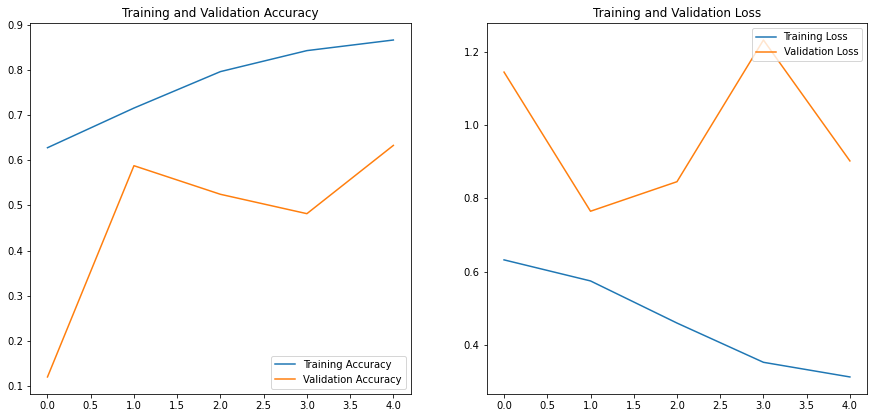

In [46]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/anaconda/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is depr

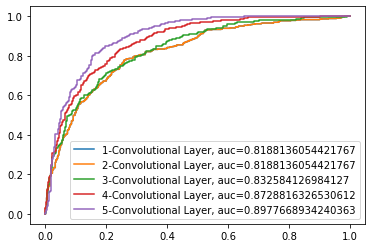

In [47]:
y_pred_proba1 = cnn2.predict_proba(x_val)
fpr1, tpr1, _ = metrics.roc_curve(y_val,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_val, y_pred_proba1)
plt.plot(fpr1,tpr1,label="1-Convolutional Layer, auc="+str(auc1))

y_pred_proba2 = cnn2.predict_proba(x_val)
fpr2, tpr2, _ = metrics.roc_curve(y_val,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_val, y_pred_proba2)
plt.plot(fpr2,tpr2,label="2-Convolutional Layer, auc="+str(auc2))

y_pred_proba3 = cnn3.predict_proba(x_val)
fpr3, tpr3, _ = metrics.roc_curve(y_val,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_val, y_pred_proba3)
plt.plot(fpr3,tpr3,label="3-Convolutional Layer, auc="+str(auc3))

y_pred_proba4 = cnn4.predict_proba(x_val)
fpr4, tpr4, _ = metrics.roc_curve(y_val,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_val, y_pred_proba4)
plt.plot(fpr4,tpr4,label="4-Convolutional Layer, auc="+str(auc4))


y_pred_proba5 = cnn5.predict_proba(x_val)
fpr5, tpr5, _ = metrics.roc_curve(y_val,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_val, y_pred_proba5)
plt.plot(fpr5,tpr5,label="5-Convolutional Layer, auc="+str(auc5))


plt.legend(loc=4)
plt.show()